In [2]:
# clear all the variables
%reset -f

In [3]:
# import the relevant libraries
import time
import numpy as np
from random import randint
import matplotlib.pyplot as plt
from scipy.stats import norm, moment

## The Hosking method
   Given a fractional Gaussian noise $X_0,X_1,\ldots$, a fractional Brownian motion sample $Y_0,Y_1,\ldots$ is obtained by taking the cumulative sum. We write $\gamma(\cdot)$ the covariance function of the (zero-mean) process, that is
$$\gamma(k)\equiv\mathbb E X_n X_{n+k}$$
   We have $\Gamma (n) = \left(\gamma(i-j)\right)_{i,j=0,\ldots ,n}$ the covariance  matrix and $c(n)=\left(\gamma(k+1)\right)_{k=0,\dots n}$ the autocovariance vector. Finally, $F(n) = \left(\mathbb 1_{[i=n-j]}\right)_{i,j=0,\ldots ,n}$ is an indicative matrix. Note that premultiplying this matrix with a column vector or postmultiplying with a row vector ‘flips’ this
vector. Then the matrix $\Gamma(n+1)$ can be split as follow:  
$$
\Gamma(n+1) = \left[ \begin{array}{cc}
1 & c(n)'\\
c(n) & \Gamma(n) \end{array} 
\right]
$$

   Define $d(n) = \Gamma(n)^{-1}c(n)$ and $\sigma^2_n\equiv1-c(n)'\Gamma(n)^{-1}c(n)$. One can check that, 
$$
\Gamma(n+1)^{-1} = \frac{1}{\sigma^2_n}\left[ \begin{array}{cc}
1 & -d(n)'\\
-d(n) & \sigma^2_n\Gamma(n)^{-1} + d(n)d'(n) \end{array} 
\right]
$$
   
   Hence for $(x, y)\in\mathbb R^{n+1}\times\mathbb R^{n}$,
$$
[
\begin{array}{cc}
y & x'
\end{array}
]
\Gamma(n+1)^{-1}
\left[
\begin{array}{c}
y\\
x
\end{array}
\right]=\frac{(y - d(n)'x)^2}{\sigma^2_n} + x'\Gamma(n)^{-1}x
$$
   
   Hence [why ?], the conditional distribution of $X_{n+1}\vert X_n,\ldots,X_0$ is gaussian with expectation $\mu_n\equiv c(n)'\Gamma(n)^{-1}(X_n \cdots X_0)'$ and variance $\sigma^2_n\equiv1-c(n)'\Gamma(n)^{-1}c(n)$.
   
   Hoskin **[cit]** introduced an algorithm to compute $d(n)$ recursively. We can see that 
$$
\Gamma(n+1) = \left[ \begin{array}{cc}
\Gamma(n) & F(n)c(n)\\
c(n)'F(n) & 1 \end{array} 
\right]
$$
hence this alternative inverse form holds:
$$
\Gamma(n+1)^{-1} = \frac{1}{\sigma^2_n}\left[ \begin{array}{cc}
\sigma^2_n\Gamma(n)^{-1} + F(n)d(n)d'(n)F(n) & -F(n)d(n)\\
-d(n)'F(n) & 1 \end{array} 
\right]
$$

Suppose we know $\mu_n, \sigma_n^2$ and $\tau(n)\equiv d(n)'F(n)c(n)=c(n)'F(n)d(n)$. It is easy to see that $\sigma$

In [4]:
# define the covariance function
def covariance(i, H):
    if i==0:
        return 1
    else:
        return ((i - 1) ** (2.0 * H) 
                - 2.0 * i ** (2.0 * H)
                + (i + 1) ** ( 2.0 * H)) / 2.0

In [5]:
def hosking(H, n, T, cum, seed = None):
    
    # the size of the return array
    size = 2 ** n
    
    # mem allocation
    phi = np.empty(size, dtype=float)
    psi = np.empty(size, dtype=float)
    cov = np.empty(size, dtype=float)
    ret = np.empty(size, dtype=float)
    
    # for debug
    np.random.seed(seed)
    
    # step 0
    v = 1
    phi[0] = 0
    ret[0] = np.random.standard_normal(1)
    
    # first compute the covariance coefficients
    for i in range(0, size):
        cov[i] = covariance(i, H);

    # main loop
    for i in range(1, size):
        phi[i - 1] = cov[i]
        
        for j in range(0, i - 1):
            psi[j] = phi[j]
            phi[i - 1] = phi[i - 1] - psi[j] * cov[i - j - 1]
            
        phi[i - 1] = phi[i - 1] / v
        
        for j in range(0, i - 1):
            phi[j] = psi[j] - phi[i - 1] * psi[i - j - 2]
        
        v = v * (1 - phi[i - 1] ** 2)
        
        ret[i] = 0.0
        
        for j in range(0, i):
            ret[i] = ret[i] + phi[j] * ret[i - j - 1]
            
        ret[i] = ret[i] + np.sqrt(v) * np.random.standard_normal(1)
 
    # rescaling
    scaling = (T / size) ** H
    ret *= scaling
        
    if cum:
        return np.cumsum(ret)
    else:
        return ret

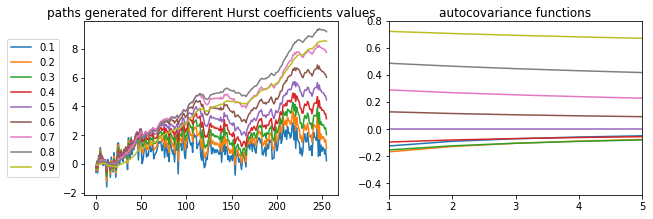

In [6]:
# step 1: we compare distributions
hurst = np.linspace(0.1, 1.0, 9, endpoint = False)
T = 10.0
size = 8

start = time.clock()

# we set the seed once for all the paths
seed = np.random.randint(0, 1000)

res1 = zip(hurst, [hosking(x, size, T, True, seed) for x in hurst])
#print("computation done in {} seconds".format(time.clock() - start))

values = np.arange(1.0,5.1,0.1)
res2 = zip(hurst, [[covariance(i, x) for i in values] for x in hurst])

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(221)
[ax1.plot(s[1], label=s[0]) for s in res1]
ax1.set_title('paths generated for different Hurst coefficients values')
ax1.legend(loc='center right', bbox_to_anchor=(-0.08, 0.5))

# plot the covariance function for selected values of H
ax2 = fig.add_subplot(222)
[ax2.plot(s[1], label=s[0]) for s in res2]
ax2.set_title('autocovariance functions')
ax2.set_xlim(values.min(), values.max())

fig.subplots_adjust(hspace=.5)
plt.show()

computation done in 52.5181714586 seconds


c:\program files\nomura\fingal64\python\python27\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


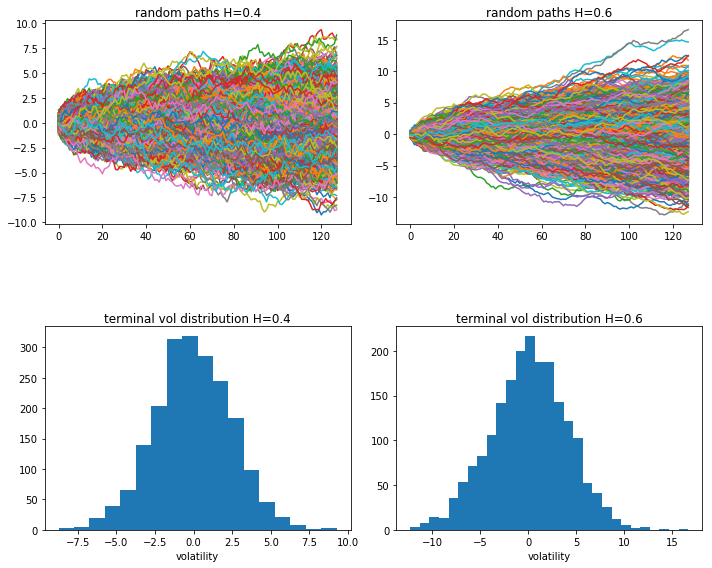

In [7]:
# step 2: generate N paths with H = 0.8 coefficient 
hurst = [0.4, 0.6]
T = 10.0
size = 7
N = 2000

start = time.clock()
res3 = [hosking(hurst[0], size, T, True) for x in range(N)]
res4 = [hosking(hurst[1], size, T, True) for x in range(N)]
print("computation done in {} seconds".format(time.clock() - start))

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(221)

ts = [[], []];
for i in res3:
    ts[0] = ts[0] + ax1.plot(i)

ax1.set_title('random paths H=' + str(hurst[0]))
ax1.legend(loc='center right', bbox_to_anchor=(-0.08, 0.5))

ax2 = fig.add_subplot(222)

for i in res4:
    ts[1] = ts[1] + ax2.plot(i)

ax2.set_title('random paths H=' + str(hurst[1]))
ax2.legend(loc='center right', bbox_to_anchor=(-0.08, 0.5))

# get the terminal values
term = [[i.get_ydata()[-1] for i in j] for j in ts]

# create the histograms
binwidth = 1

ax3 = fig.add_subplot(223)
ax3.title.set_text('terminal vol distribution H=' + str(hurst[0]))
ax3.hist(term[0], bins=np.arange(min(term[0]), max(term[0]) + binwidth, binwidth))
ax3.set_xlabel("volatility")

ax4 = fig.add_subplot(224)
ax4.title.set_text('terminal vol distribution H=' + str(hurst[1]))
ax4.hist(term[1], bins=np.arange(min(term[1]), max(term[1]) + binwidth, binwidth))
ax4.set_xlabel("volatility")

fig.tight_layout()
fig.subplots_adjust(hspace=.5)
plt.show()

In [8]:
# we compare the moments of the two distributions side by side
print([[moment(x, i) for i in range(1, 5)] for x in term])

[[0.0, 6.228368691720811, -0.25686873333440385, 121.71338803904088], [0.0, 16.015074368187424, -4.9083239049972773, 782.49207038613156]]
